In [1]:
import gym
import collections
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 200000
batch_size    = 128

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [4]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            

In [5]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [6]:
def main(learning, q=Qnet()):
    if learning == True:
        score_history = []
        env = gym.make('CartPole-v1')
        env = gym.wrappers.Monitor(env, './tmp/cartpole-v0-1',force=True)
#         q = Qnet()
        q_target = Qnet()
        q_target.load_state_dict(q.state_dict())
        memory = ReplayBuffer()

        print_interval = 50
        score = 0.0  
        optimizer = optim.Adam(q.parameters(), lr=learning_rate)

        for n_epi in range(10000):
            epsilon = max(0.05, 0.9 - 0.05*(n_epi/200)) #Linear annealing from 8% to 1%
            s = env.reset()
            done = False

            while not done:
                a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
                s_prime, r, done, info = env.step(a)
                done_mask = 0.0 if done else 1.0
                memory.put((s,a,r/100.0,s_prime, done_mask))
                s = s_prime

                score += r
                if done:
                    break

            if memory.size()>2000:
                train(q, q_target, memory, optimizer)

            if n_epi%print_interval==0 and n_epi!=0:
                q_target.load_state_dict(q.state_dict())
                print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                                n_epi, score/print_interval, memory.size(), epsilon*100))
                score_history.append(score/print_interval)
                
                if score/print_interval > 490:
                    return q, score_history
                score = 0.0
        env.close()
        
        return q, score_history
    
    if learning == False:
        score_history = []
        env = gym.make('CartPole-v1')
        env.render()
        
        q_target = Qnet()
        q_target.load_state_dict(q.state_dict())
        
        print_interval = 20
        score = 0.0
        
        for n_epi in range(100):
            epsilon = 0
            s = env.reset()
            done = False
        
            while not done:
                a = q.sample_action(torch.from_numpy(s).float(), epsilon)
                s_prime, r, done, info = env.step(a)
                s = s_prime

                score += r
                if done:
                    break

            if n_epi%print_interval==0 and n_epi!=0:
                print("n_episode :{}, score : {:.1f}".format(n_epi, score/print_interval))
                score_history.append(score/print_interval)
                score = 0.0

        env.close()
        
        return score_history

In [7]:
q, score_history = main(True)

n_episode :50, score : 21.8, n_buffer : 1090, eps : 88.8%
n_episode :100, score : 22.2, n_buffer : 2198, eps : 87.5%
n_episode :150, score : 21.9, n_buffer : 3293, eps : 86.2%
n_episode :200, score : 20.1, n_buffer : 4300, eps : 85.0%
n_episode :250, score : 23.4, n_buffer : 5469, eps : 83.8%
n_episode :300, score : 28.4, n_buffer : 6891, eps : 82.5%
n_episode :350, score : 28.4, n_buffer : 8311, eps : 81.2%
n_episode :400, score : 33.7, n_buffer : 9994, eps : 80.0%
n_episode :450, score : 28.8, n_buffer : 11435, eps : 78.8%
n_episode :500, score : 27.5, n_buffer : 12809, eps : 77.5%
n_episode :550, score : 29.0, n_buffer : 14261, eps : 76.2%
n_episode :600, score : 31.7, n_buffer : 15848, eps : 75.0%
n_episode :650, score : 32.5, n_buffer : 17475, eps : 73.8%
n_episode :700, score : 31.6, n_buffer : 19057, eps : 72.5%
n_episode :750, score : 29.7, n_buffer : 20543, eps : 71.2%
n_episode :800, score : 30.8, n_buffer : 22083, eps : 70.0%
n_episode :850, score : 34.0, n_buffer : 23784, e

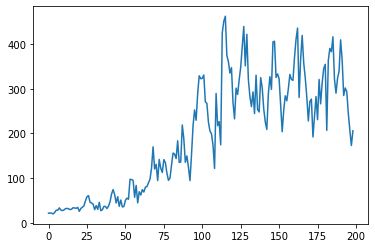

In [8]:
plt.plot(score_history)

In [9]:
score_history_test = main(False, q)

n_episode :20, score : 137.3
n_episode :40, score : 129.2
n_episode :60, score : 130.2
n_episode :80, score : 129.3


In [10]:
score_history_test

[137.3, 129.2, 130.15, 129.3]